# Natural Language Processing

* What is NLP?
* Some examples:
  * Part-of-speech tagging: identify if each word is a noun, verb, adjective, etc.)
  * Named entity recognition NER): identify person names, organizations, locations, medical codes, time expressions, quantities, monetary values, etc)
  * Question answering
  * Speech recognition
  * Text-to-speech and Speech-to-text
  * Topic modeling
  * Sentiment classification
  * Language modeling
  * Translation
  
* Some caviates: 
  * Can and will take longer to train
  * The fastai has made some improvements, but expect 1-2 hrs on real datasets, if not longer

# What will we be doing today?

## IMDB
* Sentement analysis of movie reviews and rating if something was good or bad

In [0]:
from fastai import *
from fastai.text import *

# Data Preparation

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

Our sample just has one file, let's take a look

In [3]:
df = pd.read_csv(f'{path}/texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [4]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

# Pipeline

For NLP tasks, we have a bit of a different pipeline. We will train two models, a language model which will act as our embeddings, and a classifier on top. The model itself is called ULM-FiT.

Language model: We will train on our entire corpus's language (subject), usually pretrained on your language of choice (English, Spanish, etc.)

Classifier: We load in our initial language model and pop on a classifier on top.

Our csv contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

Now if you notice, that too a bit. Why? First let's save our databunch, something you should *always* do for your langauge models

In [0]:
data_lm.save()

Now we can load it back in instantly

# Tokenizing

First step is to take our texts, and split the raw sentences into tokens to take care of either special phrases or characters. 

Here are some processes we need to take care of:
* Punctuation
* Contractions (isn't, don't)
* HTML code, etc

In [7]:
data_lm.show_batch()

text,target
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative


The texts are truncated at 100 tokens for readability. Here are some other things we did using Spacy

* 's' are grouped together
* contractions are seperated like so "did", "n't"
* Any HTML symbol has been cleaned
* Everything is lower-cased
* there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields

# Numericalization

Once we have our tokens, we can convert them to integers. These are then saved in a `vocab`, in a dictionary called `itos` (int to string)

In [8]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

# Spacy

We use spacy as the main way to actually tokenize. [See here](https://spacy.io/)

In [9]:
data_lm.train_ds.x.processor

In [0]:
tok = data_lm.train_ds.x.processor[0]
num = data_lm.train_ds.x.processor[1]

In [11]:
tok.tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

In [12]:
num.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [13]:
num.vocab.stoi.items()

dict_items([('xxunk', 0), ('xxpad', 1), ('xxbos', 2), ('xxeos', 3), ('xxfld', 4), ('xxmaj', 5), ('xxup', 6), ('xxrep', 7), ('xxwrep', 8), ('the', 9), (',', 10), ('.', 11), ('and', 12), ('a', 13), ('of', 14), ('to', 15), ('is', 16), ('it', 17), ('in', 18), ('i', 19), ('that', 20), ('this', 21), ('"', 22), ("'s", 23), ('was', 24), ('-', 25), ('\n \n ', 26), ('movie', 27), ('as', 28), ('for', 29), ('but', 30), ('with', 31), ('film', 32), ('you', 33), ('on', 34), ("n't", 35), ('not', 36), (')', 37), ('are', 38), ('(', 39), ('he', 40), ('have', 41), ('his', 42), ('be', 43), ('one', 44), ('they', 45), ('all', 46), ('at', 47), ('by', 48), ('like', 49), ('an', 50), ('so', 51), ('from', 52), ('who', 53), ('!', 54), ('there', 55), ('if', 56), ('about', 57), ('or', 58), ('just', 59), ('out', 60), ('do', 61), ('what', 62), ('her', 63), ('some', 64), ('has', 65), ('?', 66), ('very', 67), ('good', 68), ('more', 69), ("'", 70), ('no', 71), ('when', 72), ('would', 73), ('up', 74), ('were', 75), ('thei

# Full Datablock API

Below I will show you two examples of the datablock API for creating our langauge model databunch. The second is the faster version, the first shows what all we are doing

In [0]:
tokenizer = Tokenizer(SpacyTokenizer, 'en')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)]

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text',processor=processor)
       .split_none()
       .label_for_lm()
       .databunch(bs=4))

In [0]:
data = TextLMDataBunch.from_csv(path, 'texts.csv', text_cols='text')

In [17]:
data.show_batch()

idx,text
0,"back , and this time , he 's here with a vengeance . \n \n xxup ok , this movie does n't have the most xxunk script in the world , but its thematics are very clever and ask some serious questions about our society . xxmaj of course , like every xxmaj xxunk movie since the end of the 90 's , "" xxmaj the xxmaj bourne xxmaj"
1,"must take it all with an uncertain ingratiating smile in his xxunk hope for social acceptance : a typical product of the bullying of the more gifted and popular , in other words , but one the audience is apparently being invited to laugh at along with his tormentors . xxmaj unless the xxunk is to expose a darker side to the protagonists ( for which i xxunk no sign"
2,"natural cadence , which would be a problem of recording each individual 's dialogue xxunk . xxmaj on rare occasions the emotions in the voices do n't quite match those on screen ; something that should really have been avoided . xxmaj the futuristic xxunk is very attractive ( lots of glass walls / ceilings / screens , lovely smoke / xxunk / special effects ) and nice - looking"
3,good animal actions scenes which were probably pretty astonishing at the time . xxmaj clyde xxmaj beatty is n't exactly a xxunk idol . xxmaj he 's a little slight and not particularly good looking . xxmaj but that 's xxup ok . xxmaj he 's the man in that lion cage . xxmaj we know that when he ca n't take the time away from his lions to tend
4,"and xxmaj xxunk ( the torture of xxmaj xxunk xxmaj london in xxmaj czechoslovakia by xxmaj xxunk ) . xxbos xxmaj of life in ( some ) colleges . xxmaj of course there were artistic xxunk taken , but some of what you saw in this film go on in some colleges . \n \n i went to colleges in xxmaj southern xxmaj california where the races pretty much"


Using the full API, we can actually dictate what we want our tokenizer to be. For instance, we could use SentencePiece instead!

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 5.0MB/s 


In [0]:
processor = SPProcessor()

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text',processor=processor)
       .split_none()
       .label_for_lm()
       .databunch(bs=4))

In [21]:
data.show_batch()

idx,text
0,"▁has ▁his ▁career ▁been ▁on ? ▁xxmaj ▁who o sh ... ▁xxmaj ▁ ban z ai !!! ▁xxmaj ▁finally ▁this ▁was ▁directed ▁by ▁the ▁guy ▁who ▁did ▁xxmaj ▁big ▁xxmaj ▁chill ? ▁xxmaj ▁must ▁be ▁a ▁re play ▁of ▁xxmaj ▁jonestown ▁- ▁hollywood ▁style . ▁xxmaj ▁wo oo fff ! ▁xxbos ▁xxmaj ▁this ▁is ▁a ▁extremely ▁well - made ▁film . ▁xxmaj ▁the ▁acting , ▁script ▁and ▁camera - work"
1,"▁mar it al ▁situation . ▁xxmaj ▁it ' s ▁really ▁about ▁two ▁opposite s ▁who ▁must ▁face ▁why ▁their ▁marriage s ▁fell ▁apart ▁and ▁how ▁their ▁de t rimental ▁i di o sync ras ies ▁reveal ▁themselves ▁outside ▁of ▁their ▁marriage . ▁xxmaj ▁neatness , ▁the ▁character istic ▁of ▁xxmaj ▁felix ▁xxmaj ▁ungar ▁( jack ▁xxmaj ▁lemon ▁perfectly ▁cast ) ▁and ▁mess iness , ▁the ▁character istic ▁of ▁xxmaj ▁oscar"
2,"▁the ▁other ▁comments ▁before ▁watching ▁the ▁short . i ▁have ▁to ▁say ▁i ▁disagree ▁with ▁most ▁of ▁the ▁negative ▁comments ▁or ▁problems ▁people ▁have ▁had ▁with ▁it . ▁xxmaj ▁as ▁a ▁first ▁time ▁"" lon e ▁xxmaj ▁wolf "" ▁director ▁/ ▁producer , i ▁like ▁to ▁see ▁things ▁that ▁i ▁can ▁aspire ▁to , not ▁ necessar ily ▁from ▁the ▁pro ' s , ▁but ▁by ▁people ▁just ▁getting ▁their"
3,". ▁xxmaj ▁the ▁terrifying ▁thing ▁about ▁xxmaj ▁big ▁xxmaj ▁brother ▁is ▁that , ▁in ▁a ▁way , ▁it ▁has ▁some ▁points ▁behind ▁its ▁philosophy . ▁xxmaj ▁when ▁o ' brien ▁is ▁pick ing ▁at ▁xxmaj ▁winston s ▁mind ▁in ▁the ▁xxmaj ▁ministr y ▁of ▁xxmaj ▁love , ▁he ▁is ▁xxup ▁listen ing ▁to ▁everything ▁xxmaj ▁winston ▁says ▁against ▁xxmaj ▁big ▁xxmaj ▁brother . ▁xxmaj ▁the ▁fact ▁that ▁he ▁listen s"


# Training our Langage Model

Let's go back and use our Spacy tokenized databunch for this. I'm going to keep our dataset small, but idealy you should run this instead with the full IMDB dataset. I've included a method to run it at the bottom of this notebook. Our pretrained model for today will be wikitext-103, a model trained on English wikipedia articles. 

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
       .split_by_rand_pct(0.1)
       .label_for_lm()
       .databunch(bs=8))

In [0]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

Now if you noticed, we grabbed a model that had a 'fwd' name to it. We can also train a model to learn backwards! Come on Friday to see what all that is about!

In [32]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(6600, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(6600, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=6600, bias=True)
    (output_dp): RNNDropout()
  )
)

One thing we can also do to speed up training is to use something called Mixed Precision. To do this, we need everything in multiples of 8, hence our BS of 8. This helps use the CUDA cores (tensor cores) to the best of their ability

In [0]:
learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


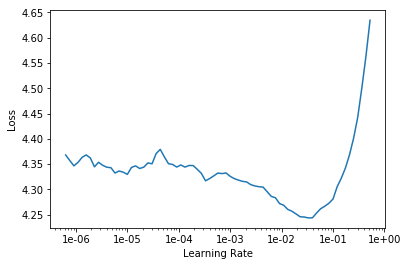

In [34]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [41]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.129189,3.786405,0.293531,00:19


Now let's unfreeze and fit the rest

In [0]:
learn.unfreeze()

Ideally we should run this for 10 epochs or so, gradually unfreezing. However with our small sample we overfit very quickly

In [43]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.676188,3.734603,0.298585,00:25


In [0]:
learn.save('fine_tuned')

How good is our model? Let's see

In [0]:
text = 'I liked this movie because'
n_words = 40
n_sentences=3

In [46]:
print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

I liked this movie because of the lack of humor in a whole film . i like Majority , the only thing a film ever did was , although they are n't totally out of place , even though it was it 's appearing
I liked this movie because i had n't read it so i 'm not directing allen about it . My fan only had the modesty of me . Yes , i recognized this movie is really the first film to be hilarious ,
I liked this movie because i think the judge of a gooey story by John Rick Inside . You could overlook this as one of real turner . The most stellar example of the movie must be


Seems like a movie review alright. Let's save our encoder and make our classifier

In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [48]:
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [50]:
len(df)

1000

In [0]:
train_df = df.iloc[:800]
valid_df = df.iloc[800:]

In [0]:
data_clas = TextClasDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, 
                                      vocab=data.vocab, bs=8)

In [56]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj the xxmaj blob starts with one of the most bizarre theme songs ever , xxunk by an uncredited xxmaj burt xxmaj xxunk of all people ! xxmaj you really have to hear it to believe it , xxmaj the xxmaj blob may be worth watching just for this song alone & my user comment summary is just a little taste of the classy lyrics ... xxmaj after this",negative
"xxbos xxmaj although recognized as the best film treatment of the difficulties of having a house in the country built ( or bought ) to your xxunk , it is not the first , nor the last . xxmaj in xxunk xxmaj jack xxmaj benny and xxmaj ann xxmaj xxunk were the leads in the film version of the comedy xxup george xxup washington xxup slept xxup here by xxmaj",positive


Let's make our model and load our encoder in

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('fine_tuned_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


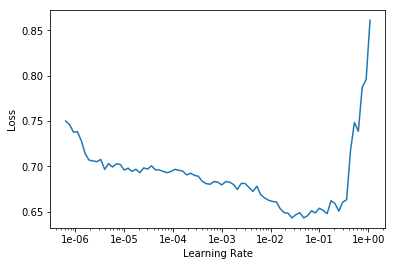

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.556252,0.513143,0.775000,00:10


In [0]:
learn.save('first')

In [64]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.479911,0.432072,0.780000,00:11


In [0]:
learn.save('third')

In [66]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.408725,0.396106,0.830000,00:20
1,0.327733,0.403870,0.805000,00:20


If we train on the entire dataset, we can achieve ~94%. I'll show the code to do that below

In [67]:
learn.predict("I really loved that movie, it was awesome!")

(Category positive, tensor(1), tensor([0.0541, 0.9459]))

# Full Dataset

* This should take you a few hours (3-5) to run. The language model training is the worst part
* In the end though, you should be able to get 94.3% accuracy

In [0]:
path = untar_data(URLs.IMDB)

We're going to include any and all language available to help our model

In [0]:
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train', 'test', 'unsup'])
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=16))

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=bs))

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))